In [1]:
#%pip install sklearn
#%pip install torch
#%pip install ipywidgets
#%pip install IProgress
#%pip install transformers

from math import sqrt
import IProgress
import os
from time import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import DistilBertModel, DistilBertTokenizer

## project structure
DATA_DIR = "/data/projects/capturingBias/research/framing/data/"  # change to "./" for current directory
DATA_NPZ = DATA_DIR + "sequences_raw.npz"
TARGETS_NPZ = DATA_DIR + "targets.npz"

## load files
data = np.load(DATA_NPZ, allow_pickle=True)
targets = np.load(TARGETS_NPZ)

sequences = data['transcriptions']
target_idx = targets['target_idx']
y_likert_crowd = targets['y_likert_crowd']
y_likert_experts = targets['y_likert_experts']
y_dominant_crowd = targets['y_dominant_crowd']
y_dominant_experts = targets['y_dominant_experts']
y_likert_combined = targets['y_likert_combined']
y_dominant_combined = targets['y_dominant_combined']


# likert
likert_expert_idx = np.where(y_likert_experts > -1)[0]
likert_crowd_idx = np.setdiff1d(np.where(y_likert_crowd > -1)[0],
                                likert_expert_idx,
                                assume_unique=True)
likert_combined_idx = np.concatenate([likert_crowd_idx,
                                      likert_expert_idx])

# dominant
dominant_expert_idx = np.where(y_dominant_experts > -1)[0]
dominant_crowd_idx = np.setdiff1d(np.where(y_dominant_crowd > -1)[0],
                                  dominant_expert_idx,
                                  assume_unique=True)
dominant_combined_idx = np.concatenate([dominant_crowd_idx,
                                        dominant_expert_idx])

In [2]:
def set_seed(seed=-1):
    if seed < 0:
        seed = np.random.randint(0, 2**32-1)

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
#set_seed(47)  # make reproducable

In [3]:
def create_splits(y, test_ratio=.2):
    train_idx = list()
    test_idx = list()
    
    strats = [np.where(y == lab)[0] for lab in np.unique(y) if lab > -1]
    for strat in strats:
        n = strat.shape[0]
        train_idx.append(strat[:int(n*(1-test_ratio))])
        test_idx.append(strat[int(n*(1-test_ratio)):])
        
    train_idx = np.concatenate(train_idx)
    test_idx = np.concatenate(test_idx)
    
    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)
    
    return (train_idx, test_idx)

def create_splits_one_hot(y):
    vec = -np.ones(y.shape[0])
    nonzero = y.nonzero()
    vec[nonzero[:,0]] = nonzero[:,1].float()
    
    return create_splits(vec)

def mkbatches_varlength(sequences, nbins):
    n = sequences.shape[0]
    # sort on length
    seq_lengths = [len(sequences[i]) for i in range(n)]
    idc = np.arange(n, dtype=np.int32)
    _, sequences_sorted_idc = zip(*sorted(zip(seq_lengths, idc)))

    return np.array_split(sequences_sorted_idc, nbins)

# Majority Class

In [4]:
from collections import Counter


def majority_class(y):
    ct = Counter(y)
    return ct.most_common(1)[0][1] / len(y)

In [5]:
majority_class_acc_crowd_likert = majority_class(y_likert_crowd[likert_crowd_idx])
majority_class_acc_experts_likert = majority_class(y_likert_experts[likert_expert_idx])
majority_class_acc_combined_likert = majority_class(y_likert_combined[likert_combined_idx])

print("Majority class accuracy on Likert labels (baseline)")
print(" crowd labels:  {:.4f}".format(majority_class_acc_crowd_likert))
print(" expert labels: {:.4f}".format(majority_class_acc_experts_likert))
print(" combined labels: {:.4f}".format(majority_class_acc_combined_likert))

majority_class_acc_crowd_dominant = majority_class(y_dominant_crowd[dominant_crowd_idx])
majority_class_acc_experts_dominant = majority_class(y_dominant_experts[dominant_expert_idx])
majority_class_acc_combined_dominant = majority_class(y_dominant_combined[dominant_combined_idx])

print("\nMajority class accuracy on Dominant labels (baseline)")
print(" crowd labels:  {:.4f}".format(majority_class_acc_crowd_dominant))
print(" expert labels: {:.4f}".format(majority_class_acc_experts_dominant))
print(" combined labels: {:.4f}".format(majority_class_acc_combined_dominant))

Majority class accuracy on Likert labels (baseline)
 crowd labels:  0.2459
 expert labels: 0.2414
 combined labels: 0.2269

Majority class accuracy on Dominant labels (baseline)
 crowd labels:  0.5536
 expert labels: 0.5345
 combined labels: 0.5439


# PyTorch Preparations

In [6]:
## convert numpy arrays to PyTorch tensors
y_likert_crowd = torch.from_numpy(y_likert_crowd)
y_likert_experts = torch.from_numpy(y_likert_experts)
y_likert_combined = torch.from_numpy(y_likert_combined)
y_dominant_crowd = torch.from_numpy(y_dominant_crowd)
y_dominant_experts = torch.from_numpy(y_dominant_experts)
y_dominant_combined = torch.from_numpy(y_dominant_combined)

In [7]:
def categorical_accuracy(y_hat, y):
    # y := 1D array of class labels
    # y_hat := 2D array of one-hot class labels
    _, labels = y_hat.max(dim=1)
    return torch.mean(torch.eq(labels, y).float())

        
def zero_pad(array: np.ndarray) -> torch.Tensor:
    n = array.shape[0]
    m = max([len(array[i]) for i in range(n)])
    
    mask = np.ones((n, m), dtype=np.int32)
    padded_array = np.zeros((n, m), dtype=np.int32)
    for i in range(n):
        l = len(array[i])
        padded_array[i,:l] = array[i]
        mask[i,l:] = np.zeros((m-l), dtype=np.int32)
        
    return (torch.from_numpy(padded_array), torch.from_numpy(mask))

def fit(model, X, y, index, lr=0.01, l2norm=0.01, n_folds=10, n_epoch=250, patience=7, state=None, finetune=False):
    n_samples = X[index].shape[0]

    loss = 0
    acc = 0
    best_state = None
    best_state_opt = None
    best_score = -1
    for fold_i in range(n_folds):
        print("Starting fold {} / {}".format(fold_i+1, n_folds), end='')
        if state is None:
            model.init()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2norm)
        else:
            model.load_state_dict(state[0])
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2norm)
            optimizer.load_state_dict(state[1])
            if finetune:
                for layer in model.layers[:-1]:
                    layer.requires_grad = False
            
        criterion = nn.CrossEntropyLoss()
        
        # early stopping
        patience_left = patience
        best_fold_score = -1
        delta = 1e-4
        best_fold_state = None
        best_fold_state_opt = None
        
        train_fold_idx, test_fold_idx  = create_splits(y[index])
        train_idx = index[train_fold_idx]
        test_idx = index[test_fold_idx]
        train_idx_batches = mkbatches_varlength(X[train_idx], nbins=4)
        for epoch in range(n_epoch):
            model.train()
            
            batch = train_idx_batches[epoch%4]
            X_batch = X[train_idx[batch]]
            X_batch, X_mask = zero_pad(X_batch)
            
            y_hat = model(X_batch.long(), X_mask.float())
            train_acc = categorical_accuracy(y_hat, y[train_idx[batch]])
            train_loss = criterion(y_hat, y[train_idx[batch]].long())
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            model.eval()
            X_test, _ = zero_pad(X[test_idx])
            test_loss = None
            with torch.no_grad():
                y_hat = model(X_test.long(), None)
                test_acc = categorical_accuracy(y_hat, y[test_idx])
                test_loss = criterion(y_hat, y[test_idx].long())
                
            train_loss = float(train_loss.item())
            test_loss = float(test_loss.item())

            if best_fold_score < 0:
                best_fold_score = test_loss
                best_fold_state = model.state_dict()
                best_fold_state_opt = optimizer.state_dict()
                            
            if patience <= 0:
                continue
            if test_loss >= best_fold_score - delta:
                patience_left -= 1
            else:
                best_fold_score = test_loss
                best_fold_state = model.state_dict()
                best_fold_state_opt = optimizer.state_dict()
                patience_left = patience
            if patience_left <= 0:
                model.load_state_dict(best_fold_state)
                optimizer.load_state_dict(best_fold_state_opt)
                break
                
        test_idx = index[create_splits(y[index])[1]]  # get new random test set to validate on
        X_test, _ = zero_pad(X[test_idx])
        with torch.no_grad():
            y_hat = model(X_test.long(), None)
            test_acc = categorical_accuracy(y_hat, y[test_idx])
            test_loss = float(criterion(y_hat, y[test_idx].long()).item())
        
        loss += test_loss
        acc += test_acc
        if best_score < 0 or best_score > test_loss:
            best_state = best_fold_state
            best_state_opt = best_fold_state_opt
            best_score = test_loss
        print(" - training accuracy: {:.4f} / loss: {:.4f} - test accuracy: {:.4f} / loss: {:.4f}".format(train_acc,
                                                                                          train_loss,
                                                                                          test_acc,
                                                                                          test_loss))
        
    loss /= n_folds
    acc /= n_folds
    print("average loss on test set: {:.4f}".format(loss))
    print("average accuracy on test set: {:.4f}".format(acc))
    
    return (acc, (best_state, best_state_opt))

class BertClassifier(nn.Module):
    def __init__(self, out_dim, p_dropout=0.05):
        super().__init__()
        
        self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.transformer.parameters():
            param.requires_grad = False
        
        hid_dim = self.transformer.config.dim
        self.layers = nn.Sequential(nn.Linear(hid_dim, hid_dim),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=p_dropout),
                                    
                                    nn.Linear(hid_dim, out_dim))
                                    
        self.softmax = nn.Softmax(dim=1)
        
        self.init()
        
    def forward(self, input_ids, mask):
        H = self.transformer(input_ids, attention_mask=mask)[0]  # (bs, seq_len, dim)
        H_pooled = H[:, 0]  # (bs, dim)
        for layer in self.layers:
            H_pooled = layer(H_pooled)
                           
        return self.softmax(H_pooled)
    
    def init(self):
        for param in self.parameters():
            if param.requires_grad:
                nn.init.normal_(param)

# Transfer Learning with Transformer

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') 

In [9]:
tokenized_sequences = [tokenizer.encode(seq[:512], add_special_tokens=True) for seq in sequences]
tokenized_sequences_length = [len(seq) for seq in tokenized_sequences]

samples_tokenized_length = np.array(tokenized_sequences_length)[target_idx]
samples_min_length = min(samples_tokenized_length)
samples_max_length = max(samples_tokenized_length)
print("Min length in sample set: %i" % samples_min_length)
print("Max length in sample set: %i" % samples_max_length)

Min length in sample set: 80
Max length in sample set: 122


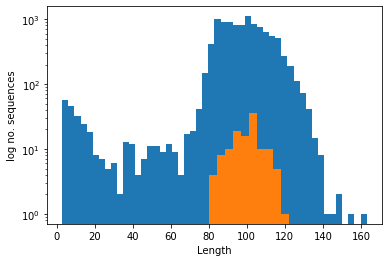

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(tokenized_sequences_length, log=True, bins=50)
plt.ylabel('log no. sequences')
plt.xlabel('Length');

plt.hist(samples_tokenized_length, log=True, bins=10)
plt.ylabel('log no. sequences')
plt.xlabel('Length');

In [11]:
# only consider sample data for now
sample_input = np.array(tokenized_sequences)[target_idx]
y_likert_crowd = y_likert_crowd[target_idx]
y_likert_experts = y_likert_experts[target_idx]
y_likert_combined = y_likert_combined[target_idx]
y_dominant_crowd = y_dominant_crowd[target_idx]
y_dominant_experts = y_dominant_experts[target_idx]
y_dominant_combined = y_dominant_combined[target_idx]

# likert
likert_expert_idx = np.where(y_likert_experts > -1)[0]
likert_crowd_idx = np.setdiff1d(np.where(y_likert_crowd > -1)[0],
                                likert_expert_idx,
                                assume_unique=True)
likert_combined_idx = np.concatenate([likert_crowd_idx,
                                      likert_expert_idx])

# dominant
dominant_expert_idx = np.where(y_dominant_experts > -1)[0]
dominant_crowd_idx = np.setdiff1d(np.where(y_dominant_crowd > -1)[0],
                                  dominant_expert_idx,
                                  assume_unique=True)
dominant_combined_idx = np.concatenate([dominant_crowd_idx,
                                        dominant_expert_idx])

In [12]:
model = BertClassifier(out_dim=2)  # num labels
## hyperparameters
lr = 0.01
n_epoch = 52  # multiple of 4 (batches)
p_dropout = 0.1

print("=== Results on expert dominant labels ===")
acc_dominant_experts, _ = fit(model, sample_input, y_dominant_experts, dominant_expert_idx, lr=lr, n_epoch=n_epoch)

print("\n=== Results on crowd dominant labels ===")
acc_dominant_crowd, _ = fit(model, sample_input, y_dominant_crowd, dominant_crowd_idx, lr=lr, n_epoch=n_epoch)

print("\n=== Results on combined dominant labels ===")
acc_dominant_combined, _ = fit(model, sample_input, y_dominant_combined, dominant_combined_idx, lr=lr, n_epoch=n_epoch)

=== Results on expert dominant labels ===
Starting fold 1 / 10 - training accuracy: 0.5455 / loss: 0.7678 - test accuracy: 0.4615 / loss: 0.8517
Starting fold 2 / 10 - training accuracy: 0.6364 / loss: 0.6769 - test accuracy: 0.4615 / loss: 0.8517
Starting fold 3 / 10 - training accuracy: 0.4545 / loss: 0.8587 - test accuracy: 0.5385 / loss: 0.7748
Starting fold 4 / 10 - training accuracy: 0.4545 / loss: 0.8587 - test accuracy: 0.5385 / loss: 0.7748
Starting fold 5 / 10 - training accuracy: 0.5455 / loss: 0.7678 - test accuracy: 0.4615 / loss: 0.8517
Starting fold 6 / 10 - training accuracy: 0.4545 / loss: 0.8587 - test accuracy: 0.5385 / loss: 0.7748
Starting fold 7 / 10 - training accuracy: 0.4545 / loss: 0.8587 - test accuracy: 0.5385 / loss: 0.7748
Starting fold 8 / 10 - training accuracy: 0.3636 / loss: 0.9496 - test accuracy: 0.5385 / loss: 0.7748
Starting fold 9 / 10 - training accuracy: 0.4545 / loss: 0.8587 - test accuracy: 0.5385 / loss: 0.7748
Starting fold 10 / 10 - trainin